# Lab session 7

In this notebook, we'll be building a vanilla DQN, a DQN with experience replay, a DQN with target networks. 
### What is DQN?

DQN is the first deep reinforcement learning method proposed by DeepMind, it overcomes unstable learning by mainly 4 techniques:
>* Experience Replay.
* Target Network.
* Clipping Rewards.
* Skipping Frames. 

To keep this lab session in time, instead of using gym atari we'll work with classic cart pole environment.
<img src='assets/cartpole.gif' width=50% />

#### Note:-
Apart from submitting code, please add your answer to questions mentioned in lab session.
Operation on cuda are fast. Try keeping all your operations on it.


--------

#### Import

In [2]:
import math, random

import cv2
import gym
import numpy as np
from collections import deque


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [3]:
import IPython.display as display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

**Note** *test()* function is a function to watch your agent play the game after training. Call the following function by passing your trained model and environment name as parameter.

It returns a list of rewards.

In [4]:
def test(env_id, model):
    """
    Method to play 30 games with trained agent.
    
    Parameters
    ----------
    env_id: str
        name of your environment
    model: model
    
    Returns
    all_test_rewards: list
        list of rewards collected in 30 episodes.
    """
    env = gym.make(env_id)
    all_test_rewards = list()
    episode_reward = 0
    episode_count = 0
    state = env.reset()
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    while True:
        if episode_count == 30:
            break
        img.set_data(env.render(mode='rgb_array')) # just update the data
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
        action = model.act(state,-1) # -ve epsilon so it always choses the policy it learned rather than random action
        next_state, reward, done, _ = env.step(action)
        if not done:
            episode_reward += reward
        else:
            state = env.reset()
            all_test_rewards.append(episode_reward)
            print(episode_reward)
            episode_reward = 0
            episode_count += 1
    print("The mean score of your agent: ", np.mean(all_test_rewards))
    env.close()
    return all_test_rewards

#### Set cuda

In [5]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

True


#### Cart Pole Environment

In [6]:
env_id = "CartPole-v0"
env = gym.make(env_id)

#### Epsilon greedy exploration
I'm sure you know the importance of epsilon. 
we are gonna plot the decay and you can see how it will behave for 10000 steps

In [7]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

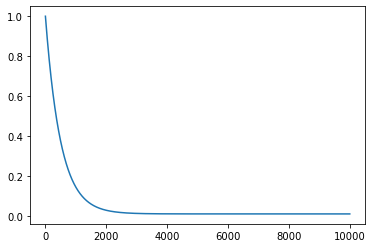

In [8]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

### Deep Q-Network

In [9]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.num_actions)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].cpu().numpy().tolist()
        else:
            action = random.randrange(self.num_actions)
        return action

In [10]:
model_base = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_base = model_base.cuda()
    
optimizer = optim.Adam(model_base.parameters())

#### Computing Temporal Difference Loss

In [11]:
def compute_td_loss_dqn(state, action, reward, next_state, done):
    """
    Parameters
    ----------
    state: numpy array
        current state of env
    action: int
        action you take in env
    reward: int
        reward for the action
    next_state: numpy array
        next state given current state and action
    done: bool
        if it's end of the episode.
    
    Returns
    -------
    loss: 1d-tensor

    """
    # converting variables to tensors
    state = Variable(torch.FloatTensor(np.float32(state)))

    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    
    action = Variable(torch.from_numpy(np.array(action)))

    reward = Variable(torch.from_numpy(np.array(reward)))
    
    done = Variable(torch.from_numpy(np.array(int(done))))
    
    # TODO:- predict q_values
    q_values = model_base.forward(state)
    
    # TODO:- predict q_values of next state
    next_q_values = model_base.forward(next_state)
    
    # TODO:- get corresponding action's q-value from predicted q-values
    # hint:- there is a very optimal and good way to do this tensor operations check (gather)
    q_value = torch.gather(q_values,0,action.long())    
    
    next_q_value = next_q_values.max(0)[0]
    
    # TODO:- calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value if not done else reward
    
    # TODO:- calculate MSE for back propagation of loss
    # Hint:- you can't do an operation between a tensor and int. keep an eye on your variable type ;).
    loss = F.mse_loss(expected_q_value , q_value)
    
    # back propagating your loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [12]:
def plot(frame_idx, rewards, losses):
    """
    Parameters
    ----------
    frame_idx: int
        frame id
    rewards: int
        accumulated reward
    losses: int
        loss
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

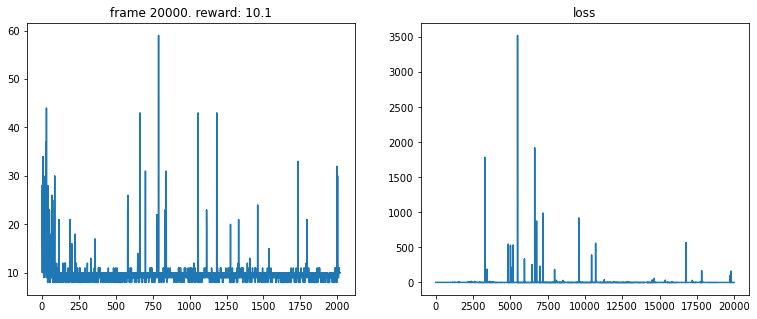

In [13]:
num_frames = 20000
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model_base.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    
    loss = compute_td_loss_dqn(state, action, reward, next_state, done)
    losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

### Deep Q-Network with Replay buffer

#### Experience Replay

Experience replay will help us to handle two things:

Avoid forgetting previous experiences.
Reduce correlations between experiences.

> * **Avoid forgetting previous experiences** : With using same network to generise we run into a problem. Since the environment is sequential we see new state, take action and overwrite the weights of our previous experience. Since all the weights are shared they form a high correlation between actions and states. We can greatly stablise our problem if we keep our previous experiences and learn from them as well. In environments like atari where your player dies and start episode again, training on these previous experiences come in handy as now agent still remember from previous experiences.
> * **Reduce correlations between experiences**: We have another problem — we know that every action affects the next state. This outputs a sequence of experience tuples which can be highly correlated.
If we train the network in sequential order, we risk our agent being influenced by the effect of this correlation.
By sampling from the replay buffer at random, we can break this correlation. This prevents action values from oscillating or diverging catastrophically.



In [14]:
model_batch = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_batch = model_batch.cuda()
    
optimizer = optim.Adam(model_batch.parameters())

#### Replay Buffer

In [15]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        """
        Parameters
        ----------
        capacity: int
            the length of your buffer
        """
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        batch_size: int
        """
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

#### Compute TD loss
Reason we are redefining it is because with replay buffer now you are gonna save your experience, gather it from your replay buffer and train model on it again. 
<br>
Now since it's a batch operation you have added an extra axis and you'll have operations in different axis.

In [16]:
def compute_td_loss_batch(batch_size):
    """
    Parameters
    ----------
    batch_size: int
    
    Returns
    -------
    loss: tensor
    """
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    
    # TODO: predict q_values. 
    # Hint:- remeber it's a batch prediction so there will be extra dimention.
    q_values = model_base.forward(state)
    
    # TODO: predict next state's q_values.
    next_q_values = model_base.forward(next_state)

    # TODO: get the q_values based on actions you took.
    #Hint:- the logic should be same as previous one but remember there is an extra dimention.
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value = next_q_values.max(1)[0]
    
    # TODO: calculate expected q value based on bellman eq.
    expected_q_value = reward + ((gamma * next_q_value) * ((-1 + done) * -1))
    
    # TODO: calculate MSE
    if expected_q_value.__sizeof__() != q_value.__sizeof__():
        print("")
    loss = F.mse_loss(expected_q_value , q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

As mentioned previously, DQN itself is not stable but we stablise it by multiple methods. Replay buffer is one of them. <br>
If your performance of DQN with replay buffer is same as previous, Try running it couple of times

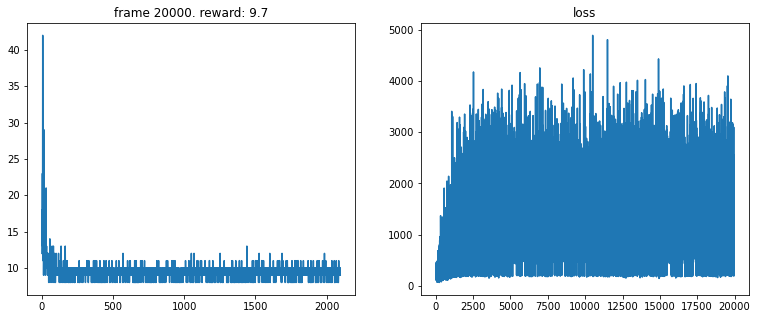

In [17]:
num_frames = 20000
batch_size = 32
gamma      = 0.99
replay_buffer = ReplayBuffer(1000)
losses = []
all_rewards = []
episode_reward = 0
count = 0
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model_batch.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_batch(batch_size)
        loss = loss.data.cpu().numpy().tolist()
        losses.append(loss)
        
    if frame_idx % 200 == 0:
        count = plot(frame_idx, all_rewards, losses)

--------

### DQN with target network

We saw in the *Deep Q Learning* that, when we want to calculate the TD error (aka the loss), we calculate the difference between the TD target (Q_target) and the current Q value (estimation of Q). <br>

But **we don’t have any idea of the real TD target**. We need to estimate it. Using the **Bellman equation**, we saw that the TD target is just the reward of taking that action at that state plus the discounted highest Q value for the next state. <br>

However, the problem is that we using the same parameters (weights) for estimating the target and the Q value. As a consequence, there is a big correlation between the TD target and the parameters (w) we are changing.

Therefore, it means that at every step of training, our Q values shift but also the target value shifts. So, we’re getting closer to our target but the target is also moving. It’s like chasing a moving target! This lead to a big oscillation in training.

To avoid this oscillation instead, we can use the idea of fixed Q-targets:

> * Using a separate network with a fixed parameter (we'll call it Target network) for estimating the TD target. <br>
while we train our DQN network.
> * After some number of steps, we copy the parameters from our DQN network to update the target network.

We’ll have more stable learning because the target function stays fixed for a while.

In current implementation you won't be using Replay buffer, just *Target network*.

In [18]:
current_model_target = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_target  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_target = current_model_target.cuda()
    target_model_target  = target_model_target.cuda()
    
optimizer = optim.Adam(current_model_target.parameters())

#### Sync model

In [19]:
def update_target(current_model, target_model):
    """
    Parameters
    ----------
    current_model: model
    
    target_model: model
    """
    target_model.load_state_dict(current_model.state_dict())

In [20]:
# initialise network as same as they may have random values in their weights
update_target(current_model_target, target_model_target)

#### Compute TD loss

In [21]:
def compute_td_loss_target(state, action, reward, next_state, done):
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action  = Variable(torch.from_numpy(np.array(action)))
    reward  = Variable(torch.from_numpy(np.array(reward)))
    done = Variable(torch.from_numpy(np.array(int(done))))
    
    #TODO:- predict q_values.
    q_values = current_model_target.forward(state)
    
    # TODO:- predict next states's q_values based on target.
    next_q_values = current_model_target.forward(next_state)
    
    # TODO:- Get q-values for actions agent took.
    q_value = q_values.gather(0, action.long())
    
    # TODO:- gather next q_values of target model.
    next_q_state_values = target_model_target.forward(next_state)
    # Hint:- next_q_values = next_q_state_values[maximum of next_q_values]
    next_q_value = next_q_state_values[torch.argmax(next_q_values)]
    
    # TODO:- calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value if not done else reward

    # TODO:- MSE
    loss = F.mse_loss(expected_q_value , q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

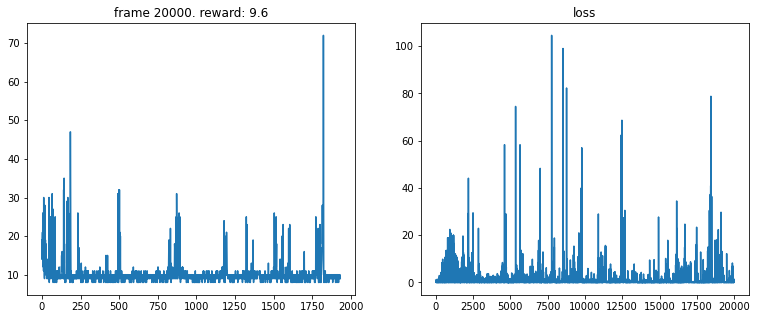

In [22]:
num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_target.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    loss = compute_td_loss_target(state, action, reward, next_state, done)
    losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_target, target_model_target)
        

--------

### DQN with target network and Replay buffer


Let's try adding Replay buffer

In [23]:
current_model_dqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_dqn  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_dqn = current_model_dqn.cuda()
    target_model_dqn  = target_model_dqn.cuda()
    
optimizer = optim.Adam(current_model_dqn.parameters())
update_target(current_model_dqn, target_model_dqn)
replay_buffer = ReplayBuffer(1000)

#### Compute TD loss

In [24]:
def compute_td_loss_target_batch(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    # Hint:- most of the operations should be similar to previous impletations.
    
    #TODO:- predict q_values.
    q_values = current_model_dqn.forward(state)
    
    # TODO:- predict next states's q_values based on target.
    next_q_values = current_model_dqn.forward(next_state)
    
    # TODO:- Get q-values for actions agent took.
    q_value = q_values.gather(1,action.unsqueeze(1)).squeeze(1)
    
    # TODO:- gather maximum of next q_values  
    next_q_state_values = target_model_target.forward(next_state)
    i = torch.argmax(next_q_values,1)
    next_q_value = next_q_state_values.gather(1,i.unsqueeze(1)).squeeze(1)
    # TODO:- calculate expected q value based on bellman eq.
    expected_q_value = reward + ((gamma * next_q_value) * ((-1 + done) * -1))
      
    # TODO MSE
    loss = F.mse_loss(q_value, expected_q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

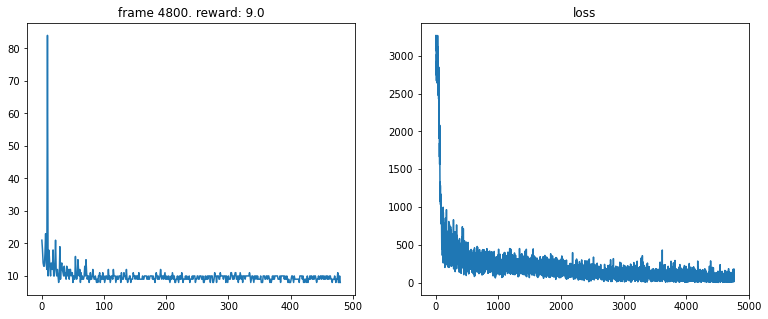

In [ ]:
num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_dqn.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_target_batch(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_dqn, target_model_dqn)

--------

### Double DQN

The target based DQN in early stages is naive, we use the action that maximizes the Q-value[next_state]. But in the early stage, this is a noisy approximation so we tend to overestimate the Q-value.

To overcome the overestimation problem we can use both the networks the local and target as we have two sets of weights, so we can cross-validate it with both sets of weights and minimize the overestimation problem.


In [ ]:
current_model_ddqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_ddqn  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_ddqn = current_model_ddqn.cuda()
    target_model_ddqn  = target_model_ddqn.cuda()
    
optimizer = optim.Adam(current_model_ddqn.parameters())
update_target(current_model_ddqn, target_model_ddqn)
replay_buffer = ReplayBuffer(1000)

In [ ]:
def compute_td_loss_doubleDQN(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action  = Variable(torch.from_numpy(np.array(action)))
    reward     = Variable(torch.from_numpy(np.array(reward)))
    done       = Variable(torch.from_numpy(np.array(int(done))))
    
    # TODO:- predict current model
    q_values = current_model_ddqn.forward(state)
    
    # TODO:- predict next value from current model
    next_q_values = current_model_ddqn.forward(next_state)
    
    # TODO:- predict next state values from target model
    next_q_target_values = target_model_ddqn.forward(next_state)
    
    # Gather only values based on action
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # TODO:- calculate next state q_values that are not over estimated
    # Hint:- next_q_value = next state q-values from target[maximum of next state q-values from current model]
    next_q_value = next_q_target_values.gather(1, torch.argmax(next_q_values, 1))
    
    # TODO:- calculate expected Q-values of future
    expected_q_value = reward + ((gamma * next_q_value) * ((-1 + done) * -1))
      
    
    # TODO:- apply MSE
    loss =F.mse_loss(q_value, expected_q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [ ]:
num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_ddqn.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    loss = compute_td_loss_doubleDQN(batch_size)
    losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_ddqn, target_model_ddqn)

-------

### Dueling Deep Q Networks
The key motivation behind this Dueling-DQN is that, for some problem statements, it is unnecessary to know the value of each action at every timestep. 
A simple example is of the Atari game Enduro, where it is not necessary to know which action to take until collision is imminent.

<img src='assets/enduro.gif' width=50% />

##### Architecture
Like the standard DQN architecture, we have layers to process data. From there, we split the network into two separate streams, one for estimating the state-value and the other for estimating state-dependent action advantages. After the two streams, the last module of the network combines the state-value and advantage outputs.


In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        self.num_actions = num_outputs
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].numpy().tolist()
        else:
            action = random.randrange(self.num_actions)
        return action

In [ ]:
current_model_dueldqn = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
target_model_dueldqn  = DuelingDQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_dueldqn = current_model_dueldqn.cuda()
    target_model_dueldqn  = target_model_dueldqn.cuda()
    
optimizer = optim.Adam(current_model_dueldqn.parameters())

replay_buffer = ReplayBuffer(1000)

#### Synchronize current policy net and target net

In [ ]:
update_target(current_model_dueldqn, target_model_dueldqn)

In [ ]:
def compute_td_loss_duelingDQN(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    
    # TODO: Predict q_values from current model
    q_values = current_model_dueldqn.forward(state)
    
    # TODO: Predict q_values from target model
    next_q_values = target_model_dueldqn(next_state)
    
    # TODO: get q_values based on action from q_values
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    
    # TODO: find maximum of next_q_values 
    # Hint: keep in mind its a batch process so find maximum in correct axis
    next_q_value = torch.max(next_q_values, 1)
    
    # TODO: calculate expected_q_value derived from bellman eq.
    expected_q_value = reward + ((gamma * next_q_value) * ((-1 + done) * -1)) 
    
    # TODO: calculate MSE between q_value and expected_q_value
    loss = F.mse_loss(q_value, expected_q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [ ]:
num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_dueldqn.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_duelingDQN(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_dueldqn, target_model_dueldqn)

------------

# Plot comparison of all agents

In [ ]:
"""
TODO: write a function to plot the performance of all previously discussed agents.
Use test function to get their perform.
"""

In [ ]:
test(env_id, model_base)
test(env_id, model_batch)
test(env_id, current_model_target)
test(env_id, current_model_dqn)
test(env_id, current_model_ddqn)
test(env_id, current_model_dueldqn)

## Playing atari Pong with Double DQN

You have successfully completed the DQN, Now we'll step up the complexity of our **Environment**. <br>
With Complex visual environment like *Space invaders*, We'll need to include following steps:
* Pre-process the input
* Make our NN more complex
> * Pre-process the input: To reduce the complexity of our states, to reduce the computation time needed for training and thus to keep network shallow we pre-process each state(frame) to convert it from RGB to grey scale. By doing this we reduce the 3 color channels (RGB) to 1 Grey. 
then we crop the top of frame where we see the score for 2 reasons
    * Score doesn't matter as we are getting reward from env, thus it's just something we don't need.
    * Score keeps on changing which introduces extra complexity adds more number of states. A small change in pixels potentially means new state
> * Make our NN more complex: We introduce CNNs to preprocess the information from states(frames). You can further read on internet the advantages of CNNs over Fully connected layer. It's out of scope for this lab session.

The new architecture will look something like this:-
<img src='assets/atari.png' width=50% />

This may seem complex but it's really not. we'll walk through step by step.

1) Preprocess frame

2) stack 4 frames: We stack frame to limit the problem of temporal limitation. 
  >* Temporal limitation: By looking at following image can you tell if the ball in the game of pong going left or right?
    <img src='assets/pong.png' width=50% /> <br>
    Thus we stack 4 frames to get context. If it's going left or right.

3) Stack CNN layers.

The above presented architecture is just an example. The complexity of your network depends on the Environment.

Different environment have different scoring system. To avoid having different architectures to play different games we often **clip rewards**.

In [ ]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

In [ ]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

In [ ]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

In [ ]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

In [ ]:
class PreProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, cfg):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = cfg.frame_width
        self.height = cfg.frame_height
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


In [ ]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)


def convert_pytorch(env):
    return ImageToPyTorch(env)

In [ ]:
def wrap_env(env, cfg,clip_rewards=True, frame_stack=True, scale=True):
    """Configure environment for DeepMind-style Atari.
    """
    env = PreProcessFrame(env, cfg)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, cfg.frame_number)
    return env

In [ ]:
class Config:
    """Config for environment"""
    def __init__(self):
        self.frame_number = 4
        self.frame_width = 84
        self.frame_height = 84
        
    def __setitem__(self, key, value):
        return setattr(self, key, value)

In [ ]:
env_id = "PongNoFrameskip-v4"
config = Config()

In [ ]:
class Environment:
    def __init__(self, env_id, config):
        self.env = gym.make(env_id)
        self.env = wrap_env(self.env, config)
        self.env = convert_pytorch(self.env)
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space
        self.spec = self.env.spec
        self.states = None

    def reset(self):
        self.states = self.env.reset()
        return self.states

    def step(self, a):
        self.states, r, done, info = self.env.step(a)
        return self.states, r, done, info

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

In [ ]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data
        else:
            action = random.randrange(env.action_space.n)
        return action

In [ ]:
env = Environment(env_id=env_id, config=config)
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 1000
replay_buffer = ReplayBuffer(10000)

update_target(current_model, target_model)

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
num_frames = 100000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        # TODO:- Based on Td_loss functions you have worked with write or
        # choose a function to reuse here and justify your choice
        loss = 
        losses.append(loss.data)
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)